In [1]:
# The C2QA pacakge is currently not published to PyPI. 
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import math

import c2qa
import c2qa.util
import matplotlib.pyplot
import numpy
import qiskit

## Displacement Gate Calibration
The following circuit is a way to calibrate the conditional displacement gate. 

In [3]:
def calibration_circuit(dist, num_qumodes = 1, num_qubits_per_mode = 4, animation_segments: int = math.nan):
    qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_mode=num_qubits_per_mode)
    qr = qiskit.QuantumRegister(size=1)
    cr = qiskit.ClassicalRegister(size=1)
    circuit = c2qa.CVCircuit(qmr, qr, cr, animation_segments=animation_segments)

    circuit.initialize([1,0], qr[0])
    circuit.cv_initialize(0, qmr[0])

    circuit.h(qr[0])
    circuit.cv_cnd_d(dist, -dist, qr[0], qmr[0])
    circuit.cv_d(1j * dist, qmr[0])
    circuit.cv_cnd_d(-dist, dist, qr[0], qmr[0])
    circuit.cv_d(-1j * dist, qmr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0], cr[0])

    return circuit

## Simulate one shot to plot Wigner function 
The statevector_simulator produces a state vector output. Then use the state vector to plot the Wigner function using the c2qa.util module.

In [4]:
circuit  = calibration_circuit(numpy.sqrt(numpy.pi) / numpy.sqrt(2))
backend = qiskit.Aer.get_backend("statevector_simulator")
job = qiskit.execute(circuit, backend)
result = job.result()

state = result.get_statevector(circuit)
counts = result.get_counts(circuit)

print("Simulated statevector:")
print(state)
print("Simulated result counts:")
print(counts)

Simulated statevector:
[-9.99999967e-01+3.86768421e-15j -1.90742113e-13+1.41499190e-06j
 -6.78787255e-06+7.35461553e-14j  6.63546875e-14-8.74957999e-06j
 -2.80769767e-05+6.90366415e-14j  1.69155691e-14-1.07346996e-04j
  9.49687008e-05-1.43060423e-13j  1.11137383e-14-6.76692002e-05j
  8.63810683e-05-1.82531806e-13j -2.01171529e-13-7.18481148e-05j
 -1.68382057e-05+1.58012079e-13j  1.65225483e-13-8.43754939e-05j
 -7.49838562e-05-1.64409314e-13j -3.25897830e-14+2.08858619e-05j
  3.15316355e-05+6.98933875e-15j -1.17510160e-13+1.09546757e-04j
  0.00000000e+00+0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j -0.00000000e+00+0.00000000e+00j
  

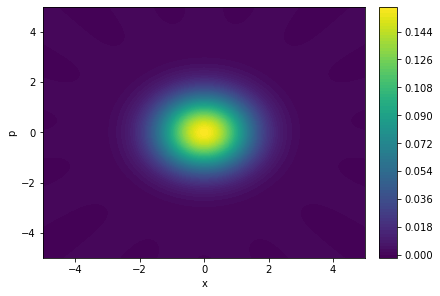

In [5]:
# Plot Fock state Wigner function with QuTiP
c2qa.util.plot_wigner_fock_state(circuit, state)

## Iterate over incremental displacements
Iteratively simulate the calibration cicruit with incremental differences in the displacement and plot probability difference results.

In [6]:
# Run the simulations
backend = qiskit.Aer.get_backend("qasm_simulator")
up = numpy.linspace(numpy.sqrt(2), 2, 20)
down = numpy.linspace(2, numpy.sqrt(2), 20)
steps = []

for _ in range(2):
    steps.extend(up[0:19])
    steps.extend(down[0:19])

x = []
y = []

for i, step in enumerate(steps):
    dist = numpy.sqrt(numpy.pi) / step
    circuit = calibration_circuit(dist)

    job = qiskit.execute(circuit, backend, shots=32)
    result = job.result()

    counts = result.get_counts(circuit)

    x.append(i)
    y.append(counts.get("0", 0) - counts.get("1", 0))

    print(f"{i}: {counts}")

0: {'0': 32}
1: {'0': 31, '1': 1}
2: {'0': 30, '1': 2}
3: {'0': 27, '1': 5}
4: {'0': 26, '1': 6}
5: {'0': 20, '1': 12}
6: {'0': 21, '1': 11}
7: {'0': 17, '1': 15}
8: {'0': 17, '1': 15}
9: {'0': 7, '1': 25}
10: {'0': 10, '1': 22}
11: {'0': 9, '1': 23}
12: {'0': 4, '1': 28}
13: {'0': 3, '1': 29}
14: {'0': 3, '1': 29}
15: {'0': 1, '1': 31}
16: {'0': 2, '1': 30}
17: {'1': 32}
18: {'1': 32}
19: {'1': 32}
20: {'1': 32}
21: {'1': 32}
22: {'1': 32}
23: {'0': 1, '1': 31}
24: {'0': 3, '1': 29}
25: {'0': 3, '1': 29}
26: {'0': 4, '1': 28}
27: {'0': 6, '1': 26}
28: {'0': 11, '1': 21}
29: {'0': 10, '1': 22}
30: {'0': 15, '1': 17}
31: {'0': 17, '1': 15}
32: {'0': 17, '1': 15}
33: {'0': 18, '1': 14}
34: {'0': 23, '1': 9}
35: {'0': 27, '1': 5}
36: {'0': 28, '1': 4}
37: {'0': 31, '1': 1}
38: {'0': 32}
39: {'0': 32}
40: {'0': 29, '1': 3}
41: {'0': 30, '1': 2}
42: {'0': 24, '1': 8}
43: {'0': 20, '1': 12}
44: {'0': 20, '1': 12}
45: {'0': 15, '1': 17}
46: {'0': 11, '1': 21}
47: {'0': 12, '1': 20}
48: {'0': 

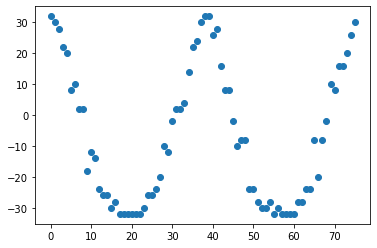

In [7]:
# Plot the results
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.show()

## Animate the circuit

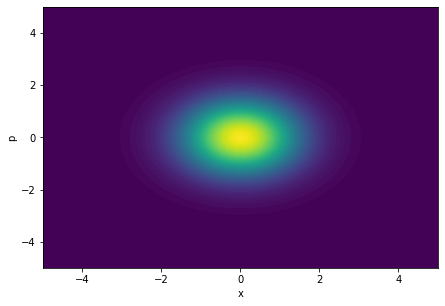

In [8]:
circuit  = calibration_circuit(dist=numpy.sqrt(numpy.pi) / numpy.sqrt(2), animation_segments=10)
backend = qiskit.Aer.get_backend("statevector_simulator")
job = qiskit.execute(circuit, backend)
result = job.result()

c2qa.util.animate_wigner_fock_state(circuit, result)